## Which type of flower is it? 
The goal for this assignment to is to classify different flowers species from a dataset(insert link) using a CNN network. Since we need to be smart in saving computing power to run on my own machine i am implementing transfer learning. The dataset we are using is fairly balanced. 
My solution will be inspired by AlexNet structure. However the goal is making a much smaller (if possible) variant on this. 

I will investigate and design the AlexNet but as an dilutad convulutation to save computation and memory speed. I am thinking of to might do the dilutation just in the beginning (since it acts as segmentation of shapes that i want to pass through the layer as early as possible to fast learn the kontur). I hope it will catch the pictures where it is over "fields" of flowers and can easier identiyfy these things   

* Dilated Convolutional Layers Early On:
Use dilated convolutions in the initial layers of the network. This helps in capturing a broader context and larger receptive fields without significantly increasing the number of parameters. It can be particularly useful for understanding global structures in the input data.
* Pooling Layers Later On:
As the network progresses, introduce pooling layers to downsample the spatial dimensions. This reduces the computational load and allows the network to focus on the most important features, helping to create a more abstract and condensed representation.


# Step 1 Dataset. (Before and after images of dataset)
Removed some images that where not even pictures of the flowers and some pictures whre the same in both maps...
This is important since we are not working with a huge dataset and every picture needs to be good quality (altough i am not removing pictures that can be challenging, that is something else, only where it was plain wrong that it wasn't pictures of flowers or wrong flowers sort. ). My philosophy is: If me as a human can't classify each image (trying to remind myself that each image is unique, and i have prior information what it is), i am not expecting my network to learn it either. Removed images where there are multiple flowers types overlapping, removed pictures that are too far away, removed pictures where the flower hasn't fully developed or withered flowers

Dandelion can be challenging because it is essentaltity two classes into one (since the flower changes so much) and it is slightly skewed since there is more pictures on when its not blooming than yello ones. There was some mixed images as well for instance a daisy in dandelion folder

## Dataset size before:
* daisy = 764
* dandelion = 1051
* rose = 784
* sunflower = 733
* tulip = 984 

## Dataset size after:
* daisy = 742
* dandelion = 1016
* rose = 759
* sunflower = 694
* tulip = 853

Total images removed = 252

* inte fanns någon blomma i
* blommor som var av fel sort i fel mapp
* blommor som var otroligt inzoomade
* blommor som speglades genom något
* blommor som var bilder på målade blommor (behöll några riktigt realistiska)
* bilder tagna från alldeles för långt ifrån där jag som människa inte kan se vad det är (tulpanerna kan man ju gissa men det är ju för jag sitter med kunskap att det är ett tulpanfält innan, så tog bort dem)
* bilder med flera olika sorters blommor i samma bild
* vissna blommor



TODO: Maybe add a Negative Dataset 

In [1]:
# Roadmap
# TODO: Go through the each datasets and remove the images that are bad. Doccument this
# TODO: Read in images (Pillow? OpenCV)
    # class preprocessing (Would be cool)
        # __init__()
        # def process_images
            # - resize images (227x227) was 320x240 (no uniform proportion)
        # def split_dataset

# TODO: Resize the images to ensure all images are the same size in a function
# TODO: Create labels for each class (5)
# TODO: Divide them into train and test split (random seed) 
# TODO: Load in the model that will be used
    # def build_model   
# TODO: Create the different layers (pooling, how many layers)
    # rembembert that it is rgb images so it has to be 3D deep for instance 32x32x3
# TODO: --> Output is 5 classes (neurons) in the last layer
# TODO: Implement transfer learning for the model 
# TODO: Train and evalutate the model
# TODO: Fine-tuning hyperparameters?
# TODO: Visualize the training and results




In [2]:
# Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path


import os

import tensorflow as tf
from keras.models import Sequential # This is used to initialize the neural network TODO: Double check
from keras.layers import Dense, Conv2D, Dropout, Flatten # This is used to build the layers of the neural network


2023-12-11 15:19:12.320477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total amount of images in dataset is: 4064
Found 4064 files belonging to 5 classes.
Using 3252 files for training.
Found 4064 files belonging to 5 classes.
Using 812 files for validation.
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Dimensions for each image batch is: (16, 227, 227, 3)
Label batch size corresponding to each tensor: (16,)


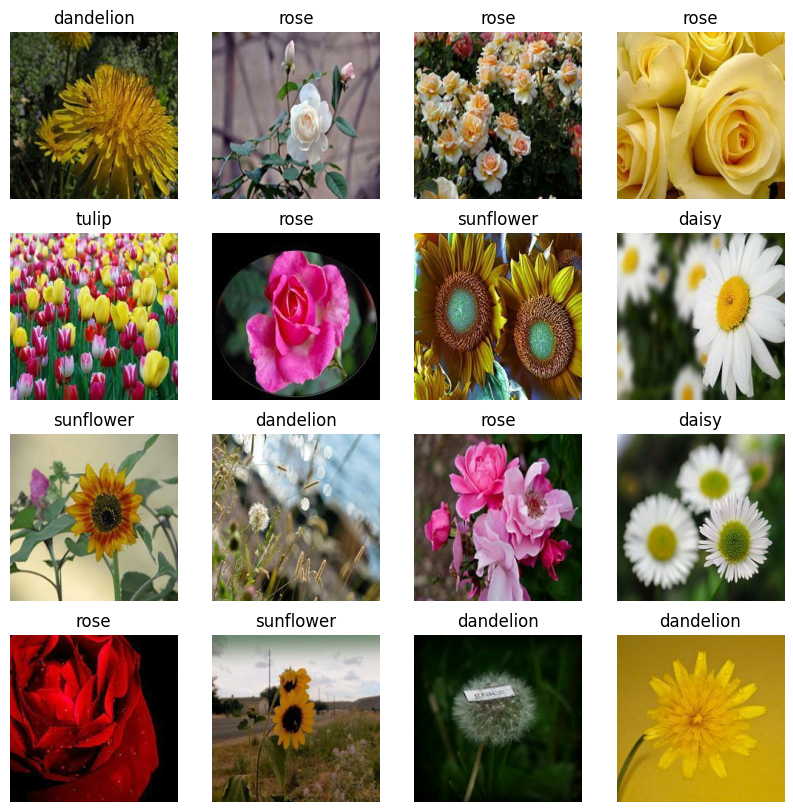

In [4]:
# Importing the dataset

DATA_DIR = Path('../dl-assignment/data/flowers').with_suffix('')
BATCH_SIZE = 16
IMG_HEIGHT = 227
IMG_WIDTH = 227
RANDOMSEED = 137
VALIDATION_SPLIT = 0.2
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# def resizeImages(target_size):
#     for image_path in DATA_DIR.glob('*/*.jpg'):
#         # Open the image and resize it (overwrites the original image, and keeps the RGB aspect of the image)
#         # TODO: Might convert the image when doing the train test split instead because i am not sure it has 3d depth
#         image = PIL.Image.open(image_path).convert('RGB').resize(target_size)
#         image.save(image_path)

# im = PIL.Image.open('data/flowers/rose/22679076_bdb4c24401_m.jpg')
# print(F"Dimensions of the images is: {im.size}")


image_count = len(list(DATA_DIR.glob('*/*.jpg')))
print(f"Total amount of images in dataset is: {image_count}")
print("======================================================")

## Normalize data here before i split it into train and test split using or perhaps i do it after the split...


def splitData():
    """Split the data into train and test split and get labels for each class
    Returns train_list, test_list (list of images) """

    train_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=RANDOMSEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    val_split = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset='validation',
        seed=RANDOMSEED,
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    )

    class_names = train_split.class_names
    print(class_names)
    
    return train_split, val_split, class_names


train_split, val_split, class_names = splitData()  # Accessing the data outside my function

# rose = list(DATA_DIR.glob('rose/*'))
# PIL.Image.open(str(rose[1]))


#TODO: Simplify this code without nested for loop and show 20 images instead of 9
# def visualizeData(train_split):
#     """Visualize the first 20 images (train_split) in the dataset"""
#     plt.figure(figsize=(16, 12))
#     for images, labels in train_split.take(1):
#         class_names = train_split.class_names
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             plt.title(class_names[labels[i]])
#             plt.axis("off")
#     plt.show()

def visualizeData(train_split):
    """" Visualizing the 20 first images from one of the splits and output the shape of the images """
    plt.figure(figsize=(10, 10))
    for images, labels in train_split.take(2): # Takes two which means it takes the first 16*2 images (batch size)
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("int"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_split:
        print("======================================================")
        print(f"Dimensions for each image batch is: {image_batch.shape}")
        print(f"Label batch size corresponding to each tensor: {labels_batch.shape}")
        break

    plt.show()



# def visualize_images(train_split, num_samples=20, cols=5):
#     """ Visualize a specified number of images """
#     plt.figure(figsize=(cols * 3, (num_samples // cols + 1) * 3))  # Adjusted figsize for better visualization

#     for i in range(min(num_samples, len(train_split))):
#         plt.subplot((num_samples // cols) + 1, cols, i + 1)
#         plt.imshow(train_split[i])
#         plt.axis("off")

#     plt.show()




visualizeData(train_split)



In [ ]:
def normalizeData(train_split, val_split):
    """ Normalize the data with tensorflow by dividing each pixel by 255 (max value of a pixel)
    Returns normalized train and validation splitrescaled """
    norm_train_split = train_split.map(lambda x, y: (x / 255.0, y))
    norm_val_split = val_split.map(lambda x, y: (x / 255.0, y))
    


In [ ]:
""" This is the part of the code where model build is constructed and also trained. 
Will need to follow the workflow how to create it.

Step 1. Standardize the data (normalize the data) (divide by 255) (this is done in the model.fit() function)
Step 1.5 Fix what type of data will be in the splits.. (This is just classes so it should be categorical perhaps?) 
Step 2. Neural network construction with the layers
Step 3. Compile the model (optimizer, loss function, metrics)
Step 4. Train the model (model.fit())
    - Investigate early stopping and double descent(?)
    - Have metrics that track the val loss and training accuracy during training (Would be nice to have it visually)
Step 5. Save the model (model.save()) (save the model and the weights)
Step 6. Make predictions (model.predict())
Step 7. Evaluate the model (model.evaluate()) (confusion matrix, accuracy etc)
Step 8. Visualize the results (plotting the results) (plotting the loss and accuracy)

"""

def normalize(train_split, val_split):
    """Normalize the data by dividing by 255"""
    
    pass


In [ ]:
""" This is the part of the code where model build is constructed and also trained. 
Will need to follow the workflow how to create it.

Step 1. Standardize the data (normalize the data) (divide by 255) (this is done in the model.fit() function)
Step 2. Neural network construction with the layers
Step 3. Compile the model (optimizer, loss function, metrics)
Step 4. Train the model (model.fit())
Step 5. Save the model (model.save()) (save the model and the weights)
Step 6. Make predictions (model.predict())
Step 7. Evaluate the model (model.evaluate()) (confusion matrix, accuracy etc)
Step 8. Visualize the results (plotting the results) (plotting the loss and accuracy)

"""







class CNN():

    def __init__(self) -> None:
        super().__init__() # This is used to inherit the parent class
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(5, activation='softmax'))
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
        

In [ ]:
# Importing the dataset

DATA_DIR = Path('../dl-assignment/data/flowers').with_suffix('.jpg')



# FLOWER_DIR = os.path.join('..', 'data', 'flowers')
# RANDOM_SEED = 137
PATH = "../dl-assignment/data/flowers/"
IMG = Image.open(PATH).convert('L').rotate(270).resize((150,150)) 



labels = [
    'daisy',
    'dandelion',
    'rose',
    'sunflower',
    'tulip'
]

labelsDict = {
    i: label for i, label in enumerate(labels) 
}

def process_images(self):
    """
    Loads in the images and Resizes the images to 227x227x3
    """

    pass



    

NameError: name 'Image' is not defined